This is an experimental notebook, that inspects the annotations dataset. It investiage all the aspects of the dataset, and tries to find some interesting insights. All relevant figures are saved in the `visualisations` folder.

In [38]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [39]:
master = json.load(open("../data/annotation-task/annotations.json"))
le_annotators = ["bence","aske","mateusz","viktor","gustav"]

FileNotFoundError: [Errno 2] No such file or directory: 'visualisations/annotation-analysis/confusion_cohens_kappa.png'

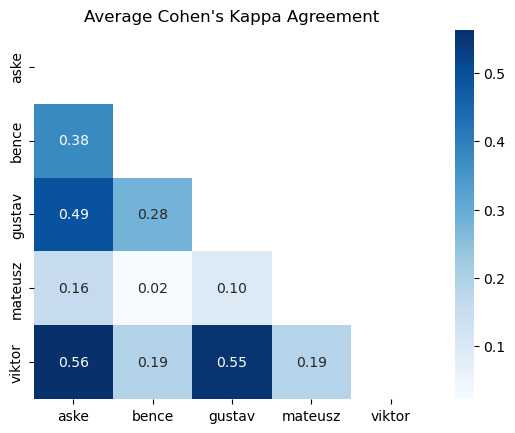

In [40]:
# Average cohens kappa agreement
annotators = [annotator for annotator in le_annotators]
collect_cohens = {annotator : defaultdict(list) for annotator in annotators}
cohens_scores = [master[entry]["inter-annotation-agreement"] for entry in master]

for overview in cohens_scores:

    for annotator_one in overview:
        for annotator_two in overview[annotator_one]:
    
            collect_cohens[annotator_one][annotator_two].append(overview[annotator_one][annotator_two])

# create empty pandas dataframe 
cohens_df = pd.DataFrame(index = sorted(annotators),columns=sorted(annotators))
for annotator_one in collect_cohens:
    for annotator_two in collect_cohens[annotator_one]:
        cohens_df.loc[annotator_one,annotator_two] = np.mean(collect_cohens[annotator_one][annotator_two])

# create a mask to hide the upper triangle
mask = np.zeros_like(cohens_df, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# fill cohens_df with 1 on nan
cohens_df.fillna(1, inplace=True)

# confusion matrix from cohens_df
sns.heatmap(cohens_df, annot=True, cmap="Blues", fmt=".2f", mask=mask)
plt.title("Average Cohen's Kappa Agreement")
plt.savefig("visualisations/annotation-analysis/confusion_cohens_kappa.png")
plt.clf()

In [ ]:
# Average fleiss kappa agreement and distribution plot
fleis_scores = [master[entry]["fleiss_kappa_score"] for entry in master]
valid_scores = [score for score in fleis_scores if not np.isnan(score)]
print(f"Average Fleiss Kappa Agreement: {np.mean(valid_scores):.3f}")
sns.displot(fleis_scores, kde=True, bins=15, label="Fleiss Kappa Agreement")
plt.xlabel("Fleiss Kappa Score")
plt.ylabel("Number of Entries")
plt.title("Fleiss Kappa Agreement Distribution")
plt.tight_layout()
plt.savefig("../visualisations/annotation-analysis/fleiss_kappa_distribution.png")
plt.clf()

In [41]:
# Number of annotated posts
counts = defaultdict(int)
for entry in master:
    for annotator in master[entry]["annotations"]:
        counts[annotator] += 1

# Plot the number of annotated posts

sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Number of annotated posts")
plt.savefig("../visualisations/annotation-analysis/number_of_annotated_posts.png")
plt.clf()


<Figure size 640x480 with 0 Axes>

In [42]:
# Distribution of posts on dates and subreddit
import datetime

# init empty df
for_the_plot = pd.DataFrame(columns=["date","subreddit","count"])
subreddits = sorted(list(set([master[entry]["subreddit"] for entry in master])))
dates = sorted(list(set([datetime.datetime.strptime(master[entry]["date"], "%Y_%m_%d").date() for entry in master])))

for date in dates:
    # insert row for each subreddit with count 0 using concat
    for subreddit in subreddits:
        for_the_plot = for_the_plot.append({"date": date, "subreddit": subreddit, "count": 0}, ignore_index=True)

for entry in master:
    date = datetime.datetime.strptime(master[entry]["date"], "%Y_%m_%d").date()
    subreddit = master[entry]["subreddit"]
    
    # increment count where date and subreddit match
    for_the_plot.loc[(for_the_plot["date"] == date) & (for_the_plot["subreddit"] == subreddit), "count"] += 1
for_the_plot.columns

Index(['date', 'subreddit', 'count'], dtype='object')

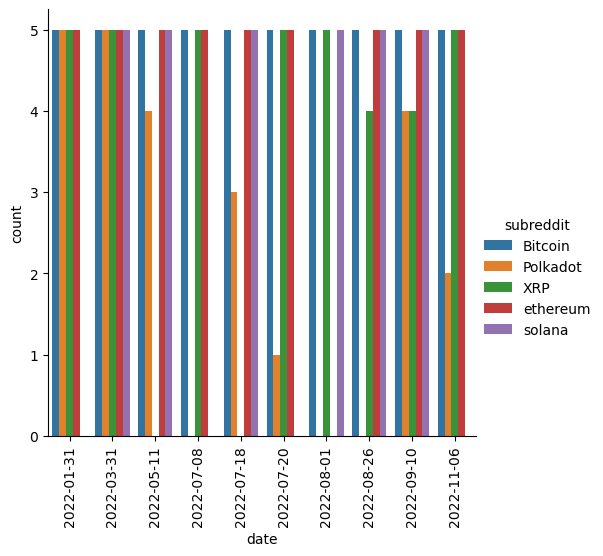

<Figure size 640x480 with 0 Axes>

In [43]:
# plot the distribution
sns.catplot(data=for_the_plot, kind="bar",x="date", y="count", hue="subreddit")
plt.xticks(rotation=90)
plt.show()
plt.clf()

In [44]:
# convert "for_the_plot" have date as index and subreddit as columns. count as values
for_the_plot = for_the_plot.pivot(index="date", columns="subreddit", values="count")
for_the_plot.to_latex("../visualisations/annotation-analysis-reddit-counts-per-day.tex")

In [45]:
# Distribution of how often we annoted each category
counts = {annotator:defaultdict(int) for annotator in le_annotators}
for entry in master:
    for annotator in master[entry]["annotations"]:
        for category in master[entry]["annotations"][annotator]:
            counts[annotator][category] += 1
            counts[annotator]["total"] += 1

In [46]:
# numerical values of the counts
for_the_latex = pd.DataFrame()
for annotator in annotators:
    for_the_latex = for_the_latex.append(counts[annotator], ignore_index=True)
for_the_latex.index = annotators
# Divide by total and multiply by 100 to get percentages excluding the total column
for_the_latex = for_the_latex.div(for_the_latex["total"], axis=0).mul(100).drop("total", axis=1)
# fill nan with 0
for_the_latex.fillna(0, inplace=True)
# sort the index
for_the_latex.sort_index(inplace=True)
# add avg row in the bottom
for_the_latex.loc["Mean"] = for_the_latex.mean()
# round to 2 decimals
for_the_latex = for_the_latex.round(2)
# sort by the "mean" row
for_the_latex = for_the_latex.sort_values(by="Mean", axis=1, ascending=False)
for_the_latex.to_latex("../visualisations/annotation-analysis-annotation_statistics.tex")
# for_the_latex

In [47]:
for_the_emotion_plot = pd.DataFrame(columns=["annotator","emotion","count"])
for annotator in counts:
    for emotion in counts[annotator]:
        if emotion != "total":
            for_the_emotion_plot = for_the_emotion_plot.append({"annotator": annotator, "emotion": emotion, "count": counts[annotator][emotion]/counts[annotator]["total"]}, ignore_index=True)
            
# plot the distribution
sns.catplot(data=for_the_emotion_plot, kind="bar",x="annotator", y="count", hue="emotion")
plt.title("Normalized count of emotions")
plt.xticks(rotation=90)
plt.savefig("../visualisations/annotation-analysis/normalized_count_of_emotions.png")
plt.clf()

<Figure size 626.375x500 with 0 Axes>

In [48]:
for_the_emotion_plot = pd.DataFrame(columns=["annotator","emotion","count"])
for annotator in counts:
    for emotion in counts[annotator]:
        if emotion not in ["total","Knowledge"]:
            for_the_emotion_plot = for_the_emotion_plot.append({"annotator": annotator, "emotion": emotion, "count": counts[annotator][emotion]/counts[annotator]["total"]}, ignore_index=True)
            
# plot the distribution
sns.catplot(data=for_the_emotion_plot, kind="bar",x="annotator", y="count", hue="emotion")
plt.title("Normalized count of emotions (without Knowledge)")
plt.xticks(rotation=90)
plt.savefig("../visualisations/annotation-analysis/normalized_count_of_emotions_without_knowledge.png")
plt.clf()

<Figure size 615.875x500 with 0 Axes>